- 基于30w条维基百科中文数据训练得到word2vec模型 用于计算词语相似度
- 基于lac分词模型给出3.3w名用户的分词与词性标注结果
- 最终给出每个用户的兴趣的概率预测值

用户规模3.3w/5.7w

In [2]:
import numpy as np
import pandas as pd
import time
import gensim
from gensim.models import Word2Vec
from tqdm import tqdm

- 导入用户兴趣相关词库

In [3]:
df_lottery = pd.read_csv(r'D:\datasets\qianyi\user_label\lottery.csv')   #与抽奖相关的词库，评分是该单词与抽奖的相似度
df_lottery

,word,score
0,抽奖,1.000000
1,转蛋,0.766024
2,转蛋机,0.736586
3,折价券,0.728505
4,抽卡,0.723283
5,奖品,0.713563
6,抽选,0.708538
7,赠奖,0.705358
8,抽奖券,0.698782
9,领券,0.689195


In [3]:
# df_lottery = df_lottery .append({'lottery_similar_word':'抽奖','score':wiki30_model.wv.similarity('抽奖','抽奖')},ignore_index=True)
# df_lottery

In [5]:
df_lottery.sort_values(by='score',inplace=True,ascending=False)
df_lottery = df_lottery.reset_index(drop=True)                        #按照相似度对抽奖进行降序排列
df_lottery

,word,score
0,抽奖,1.000000
1,转蛋,0.766024
2,转蛋机,0.736586
3,折价券,0.728505
4,抽卡,0.723283
5,奖品,0.713563
6,抽选,0.708538
7,赠奖,0.705358
8,抽奖券,0.698782
9,领券,0.689195


In [5]:
df_lottery.to_csv('lottery_similar.csv',index=False)

In [7]:
df_tweet = pd.read_csv(r'D:\datasets\data_test\3.3w用户分词1k内非空.csv')  #分词结果由lac模型得到    
'''
该表格文件包含了发帖用户的帖子的分词结果以及词性筛选的结果
'''
df_tweet

,Unnamed: 0,user_id,content,content_length,content_seq,content_select
0,0,1634847757,觉醒年代yyds！！！！！！ 觉醒年代葛树贵真实的结局觉醒年代 让很多人知道了一个从没听...,999,"[' ', '觉醒', '觉醒', '葛树贵', '真实', '结局', '觉醒', '很...","[' ', '葛树贵', '结局', '很多人', '葛树贵', '长辛店', '京郊',..."
1,1,6121645465,哈哈哈手机立刻把音量调小 妆效好美啊 太可爱了吧 猪姐太美了 看饿了 忍不住！ 疯狂...,999,"['手机', '音量', '妆效', '好美', '猪姐', ' ', ' ', '...","['手机', '音量', '妆效', '猪姐', ' ', ' ', ' ', '..."
2,2,5982298619,少年终会变成光，飞往星辰大海 我也要加油～ 铭记！铭记历史！永怀先烈，吾辈自强！ 我酸了 真...,999,"['飞往', '星辰', '大海', '加油', '铭记', '铭记', '历史', '先烈...","['星辰', '大海', '历史', '先烈', '吾辈', '犯规', ' 共产党', ..."
3,3,2688638604,沾 中国共产党100年 因为做了吃力不讨好的事情觉得好难过睡不着眼泪都掉下来 然后忘记撕的双...,999,"['中国共产党', '100年', '吃力不讨好', '好难过', '眼泪', '掉下来',...","['中国共产党', '眼泪', '双眼皮贴', '学姐', '毕业典礼', '舍友', '舍..."
4,4,7267921831,2021年第26周 早:红豆薏米糊+失败的厚蛋烧（但味道能吃） 中:爆炒非常+红苋菜+酱鸭 ...,999,"['2021年', '第26周', '红豆', '薏米糊+', '失败', '味道', '爆...","['红豆', '薏米糊+', '味道', '红豆', '薏米', '糊口感', '菜单', ..."
...,...,...,...,...,...,...
33785,33785,1860299730,qq,5,"[' ', 'qq']","[' ', 'qq']"
33786,33786,5608873136,透风,5,"['透风', ' ']","['透风', ' ']"
33787,33787,7592945242,橘子工厂,5,"['橘子', '工厂']","['橘子', '工厂']"
33788,33788,3805494971,玻璃肠胃,5,"['玻璃', '肠胃']","['玻璃', '肠胃']"


- 导入训练得到的word2vec模型（基于30w条中文语料库）

In [8]:
inp = r'D:\datasets\qianyi\user_label\model\wikich\wikich30w.model'       

In [9]:
wiki30_model = gensim.models.Word2Vec.load(inp)                  #加载通过中文维基百科数据集训练得到的word2vec模型

In [10]:
wiki30_model.wv.similar_by_word('旅游',topn=10)                  #检验模型的运行效果

[('travel', 0.7928604483604431),
 ('旅行团', 0.7741164565086365),
 ('bhogle', 0.7676227688789368),
 ('自驾游', 0.7594655156135559),
 ('不思溢', 0.7434413433074951),
 ('刘幸钰', 0.7415869235992432),
 ('自助游', 0.740311324596405),
 ('香港游', 0.7395221590995789),
 ('导游', 0.7391347289085388),
 ('吊靴', 0.738724946975708)]

In [11]:
len(wiki30_model.wv.index_to_key)                                #训练得到Word2vec模型的词向量的个数

1145213

In [12]:
wiki30_model.wv.similarity('抽奖','抽奖')             #检验两个词语的相似度

1.0

In [14]:
wiki30_model.wv.similarity('抽奖','网游')

0.4567163

In [15]:
wiki30_model.wv.similarity('抽奖','中奖')

0.6890129

## 用户对抽奖兴趣值的填充 

### 计算第一个用户与'抽奖'的相关度

In [16]:
start_time = time.time()

a = 0
interest_score = []
interest_related = 0
for i in range(len(eval(df_tweet['content_select'][a]))):          
    try:
        b = wiki30_model.wv.similarity('抽奖',eval(df_tweet['content_select'][a])[i])
        interest_score.append(b) 
        i += 1
        interest_related += 1
    except KeyError:                                 #异常排除，处理分词结果不在word2vec模型中的情况
        interest_score.append(0)
print(interest_score)
print(interest_related)
if interest_related==0:
    print(0)
else:
    print(np.sum(interest_score)/interest_related)    #返回该拥护帖子所有分词结果与指定抽奖词库词语之间相似度的平均值
    
end_time = time.time()
print(end_time-start_time)

[0, 0.35556623, 0.3892132, 0, 0.35556623, 0.20639622, 0.21836978, 0.37429407, 0.34042963, 0.35556623, 0, 0.4234055, 0.43819007, 0.31466147, 0.41270125, 0, 0.29525793, 0, 0.35622442, 0.15363425, 0.15363425, 0.22674051, 0.35556623, 0.3892132, 0, 0.35556623, 0.20639622, 0.21836978, 0.37429407, 0.34042963, 0.35556623, 0, 0.4234055, 0.43819007, 0.31466147, 0.41270125, 0, 0.32389393, 0, 0.21028537, 0, 0, 0, 0.30481416, 0.2929745, 0.39822295, 0.3058155, 0.30481416, 0, 0, 0.4063923, 0.30897167, 0.2590098, 0.26761797, 0.34523764, 0.45304546, 0.26761797, 0.34523764, 0.3767135, 0, 0.12390158, 0.26761797, 0.34523764, 0.3767135, 0.3781703, 0, 0.40537634, 0.3154226, 0.3154226, 0.33724138, 0.44070047, 0.44780508, 0, 0.3154226, 0.41344628, 0.25853372, 0.36504298, 0.38414797, 0.40537634, 0.38414797, 0.3154226, 0.44070047, 0.23606136, 0.29887378, 0.3223178, 0.2618516, 0.43922558, 0, 0.20957269, 0.37872446, 0.38034642, 0.3004572, 0, 0.43202353, 0.2649437, 0.38034642, 0.25237, 0.2884898, 0.25237, 0.154113

### 计算第一个用户对‘抽奖’的兴趣值 

In [21]:
def interest_lottery_one(x,y=0):              #x为第x+1个user,y为词库的第y+1个单词
    interest_score = []
    interest_related = 0
    for i in range(len(eval(df_tweet['content_select'][x]))):
        try:
            a = wiki30_model.wv.similarity(eval(df_tweet['content_select'][x])[i],
                                           df_lottery['word'][y])
            interest_score.append(a)
            i += 1
            interest_related += 1
        except KeyError:
            interest_score.append(0)
    if interest_related == 0:
        return 0
    else:
        return np.sum(interest_score)/interest_related  
    
# def interest_lottery_stock(x):
#     lottery_similar_score = []
#     num = 0
#     for i in range(len(df_lottery['lottery_similar_word'])):
#         lottery_score = interest_lottery_one(x,i)
#         lottery_similar_score.append(lottery_score)
#         if lottery_score != 0:
#             num+=1   
#     return np.sum(lottery_similar_score)/num
#     return np.sum(lottery_similar_score)/num,lottery_similar_score,num
#     print(lottery_similar_score)
#     print(num)
#     print(np.sum(lottery_similar_score)/num)
   

In [22]:
interest_lottery_one(0)             #第一个用户帖子分词结果与'抽奖'的相似度

0.3326461401064785

In [23]:
def interest_lottery_stock(x):
    interest_score = []
    num = 0
    for i in range(len(eval(df_tweet['content_select'][x]))):
        for j in range(len(df_lottery['word'])):
            try:
                a = wiki30_model.wv.similarity(eval(df_tweet['content_select'][x])[i],
                                           df_lottery['word'][j])
                interest_score.append(a)
                j += 1
                num += 1
            except KeyError:
                interest_score.append(0)
        i += 1
    if num == 0:
        return 0
    else:
        return np.sum(interest_score)/num
#         return np.sum(interest_score)/num,interest_score,num


In [24]:
interest_lottery_stock(0)             #第一个用户帖子分词结果与抽奖词库的相似度

0.35295752268201114

In [25]:
start_time = time.time()
print(interest_lottery_stock(0))
end_time = time.time()
print(end_time-start_time) 

0.35295752268201114
1.4740891456604004


In [26]:
interest_lottery_one(3,2)             #第4个用户的帖子分词结果与词库第三个词语的相似度

0.41812623936240956

In [27]:
interest_lottery_stock(4)

0.3890659675583607

In [28]:
start_time = time.time()
print(interest_lottery _stock(90))
end_time = time.time()
print(end_time-start_time)

0.3478822484710315
0.9724280834197998


In [29]:
start_time = time.time()
print(interest_lottery_stock(1236))
end_time = time.time()
print(end_time-start_time)

0.38766722035844153
0.42489171028137207


In [30]:
start_time = time.time()
print(interest_lottery_stock(384))
end_time = time.time()
print(end_time-start_time)

0.34793944409322225
0.7100684642791748


In [31]:
len(eval(df_tweet['content_select'][1236]))         #第1237个用户的分词数目

58

In [32]:
len(df_tweet)                                       #用户总数目

33790

In [33]:
from tqdm import tqdm
import time
start_time = time.time()

lottery_interest_value = []

for i in tqdm(range(len(df_tweet)),desc='demo: '):
    lottery_interest_value.append(interest_lottery_stock(i))
print(lottery_interest_value)                          #由上述函数给出用户对抽奖的兴趣度预测值

end_time = time.time()
print(end_time-start_time)
# df_tweet['lottery_interest_value'] = pd.Series([interest_lottery_stock(i)\
#                                             for i in tqdm(range(len(df_tweet)),desc='demo: ')])
# print(df_tweet['lottery_interest_value'])

demo: 100%|████████████████████████████████████████████████████████████████████| 33790/33790 [1:05:49<00:00,  8.56it/s]

[0.35295752268201114, 0.35609315809766434, 0.35747230420452963, 0.38113184306815223, 0.3890659675583607, 0.38052709542186913, 0.45807567869684074, 0.37830467977255666, 0.3727912966737418, 0.4013267651606495, 0.3910284603157146, 0.3752171242688222, 0.38326931240536816, 0.32398528875027044, 0.4626936590218026, 0.3720404445796534, 0.3607080455066524, 0.37394445842378254, 0.3683937319302839, 0.36956209980360255, 0.36270583055982375, 0.3754924314414583, 0.3733324737447064, 0.35364149136933554, 0.37920932123340495, 0.3797926680237903, 0.384098305453635, 0.388516544237356, 0.46924353290379534, 0.48310713210912554, 0.3727362595785935, 0.4099978678190934, 0.3587333604631696, 0.3911985931787124, 0.3589803689059592, 0.3733106510780095, 0.392091947528861, 0.3613069142909326, 0.3867114032083272, 0.3596546891192034, 0.3725607780635175, 0.37198367010816824, 0.3394208082698539, 0.37427377614977214, 0.33851874702988777, 0.3712777712884634, 0.3754173240878021, 0.32870494522493215, 0.4166723758301194, 0.

<font color=red>运行时长66min</font>

In [34]:
df_tweet['score'] = pd.Series(lottery_interest_value)
df_tweet

,Unnamed: 0,user_id,content,content_length,content_seq,content_select,score
0,0,1634847757,觉醒年代yyds！！！！！！ 觉醒年代葛树贵真实的结局觉醒年代 让很多人知道了一个从没听...,999,"[' ', '觉醒', '觉醒', '葛树贵', '真实', '结局', '觉醒', '很...","[' ', '葛树贵', '结局', '很多人', '葛树贵', '长辛店', '京郊',...",0.352958
1,1,6121645465,哈哈哈手机立刻把音量调小 妆效好美啊 太可爱了吧 猪姐太美了 看饿了 忍不住！ 疯狂...,999,"['手机', '音量', '妆效', '好美', '猪姐', ' ', ' ', '...","['手机', '音量', '妆效', '猪姐', ' ', ' ', ' ', '...",0.356093
2,2,5982298619,少年终会变成光，飞往星辰大海 我也要加油～ 铭记！铭记历史！永怀先烈，吾辈自强！ 我酸了 真...,999,"['飞往', '星辰', '大海', '加油', '铭记', '铭记', '历史', '先烈...","['星辰', '大海', '历史', '先烈', '吾辈', '犯规', ' 共产党', ...",0.357472
3,3,2688638604,沾 中国共产党100年 因为做了吃力不讨好的事情觉得好难过睡不着眼泪都掉下来 然后忘记撕的双...,999,"['中国共产党', '100年', '吃力不讨好', '好难过', '眼泪', '掉下来',...","['中国共产党', '眼泪', '双眼皮贴', '学姐', '毕业典礼', '舍友', '舍...",0.381132
4,4,7267921831,2021年第26周 早:红豆薏米糊+失败的厚蛋烧（但味道能吃） 中:爆炒非常+红苋菜+酱鸭 ...,999,"['2021年', '第26周', '红豆', '薏米糊+', '失败', '味道', '爆...","['红豆', '薏米糊+', '味道', '红豆', '薏米', '糊口感', '菜单', ...",0.389066
...,...,...,...,...,...,...,...
33785,33785,1860299730,qq,5,"[' ', 'qq']","[' ', 'qq']",0.427860
33786,33786,5608873136,透风,5,"['透风', ' ']","['透风', ' ']",0.419424
33787,33787,7592945242,橘子工厂,5,"['橘子', '工厂']","['橘子', '工厂']",0.397501
33788,33788,3805494971,玻璃肠胃,5,"['玻璃', '肠胃']","['玻璃', '肠胃']",0.350565


In [35]:
df_tweet['score'].describe()

count    33790.000000
mean         0.377159
std          0.079274
min          0.000000
25%          0.356040
50%          0.377339
75%          0.406426
max          0.671925
Name: score, dtype: float64

In [36]:
score_max = np.max(df_tweet['score'])
score_min = np.min(df_tweet['score'])
score_mean = np.mean(df_tweet['score'])
score_std = np.std(df_tweet['score'])

In [37]:
score_max

0.6719250112045102

In [39]:
score_mean

0.3771594929098897

- 散点图

In [40]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'SimHei'

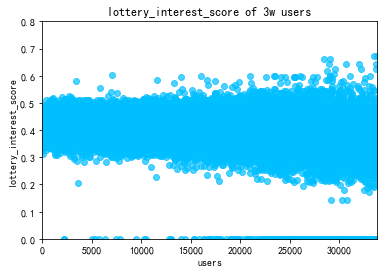

In [42]:
plt.xlim(0, len(df_tweet))
plt.ylim(0, 0.8)
plt.axis()
# 设置title和x，y轴的label
plt.title("lottery_interest_score of 3w users")
plt.xlabel("users")
plt.ylabel("lottery_interest_score")
plt.scatter(np.arange(len(df_tweet)), df_tweet['score'],color='deepskyblue',alpha=0.7)
plt.show()

## min-max标准化（Min-Max Normalization）

### 化为0-1上的小数

In [43]:
df_tweet['score_lin'] = df_tweet['score'].\
apply(lambda x: (x-score_min)/(score_max-score_min))

In [44]:
df_tweet['score_lin']

0        0.525293
1        0.529960
2        0.532012
3        0.567224
4        0.579032
           ...   
33785    0.636767
33786    0.624212
33787    0.591585
33788    0.521732
33789    0.487675
Name: score_lin, Length: 33790, dtype: float64

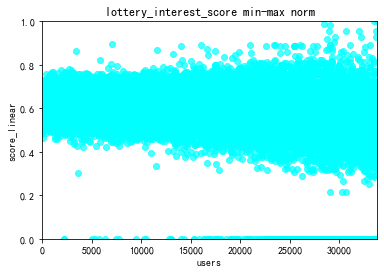

In [45]:
plt.xlim(0, len(df_tweet))
plt.ylim(0, 1)
plt.axis()
# 设置title和x，y轴的label
plt.title("lottery_interest_score min-max norm")
plt.xlabel("users")
plt.ylabel("score_linear")
plt.scatter(np.arange(len(df_tweet)), df_tweet['score_lin'],color='cyan',alpha=0.7)
plt.show()

## z-score标准化（Z-score standardization）

### 化为标准正太分布

In [46]:
df_tweet['score_std'] = df_tweet['score'].\
apply(lambda x: (x-score_mean)/score_std)
df_tweet['score_std']

0       -0.305299
1       -0.265744
2       -0.248347
3        0.050110
4        0.150196
           ...   
33785    0.639566
33786    0.533148
33787    0.256595
33788   -0.335482
33789   -0.624151
Name: score_std, Length: 33790, dtype: float64

E:\software\miniconda\envs\nlp\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\software\miniconda\envs\nlp\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


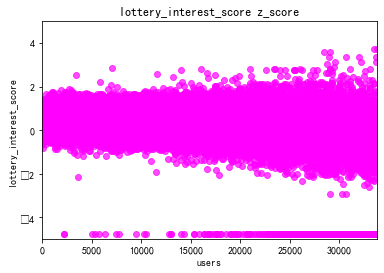

In [47]:
plt.xlim(0, len(df_tweet))
plt.ylim(-5, 5)
plt.axis()
# 设置title和x，y轴的label
plt.title("lottery_interest_score z_score")
plt.xlabel("users")
plt.ylabel("lottery_interest_score")
plt.scatter(np.arange(len(df_tweet)), df_tweet['score_std'],color='magenta',alpha=0.7)
plt.show()

## 验证

In [48]:
df_tweet

,Unnamed: 0,user_id,content,content_length,content_seq,content_select,score,score_lin,score_std
0,0,1634847757,觉醒年代yyds！！！！！！ 觉醒年代葛树贵真实的结局觉醒年代 让很多人知道了一个从没听...,999,"[' ', '觉醒', '觉醒', '葛树贵', '真实', '结局', '觉醒', '很...","[' ', '葛树贵', '结局', '很多人', '葛树贵', '长辛店', '京郊',...",0.352958,0.525293,-0.305299
1,1,6121645465,哈哈哈手机立刻把音量调小 妆效好美啊 太可爱了吧 猪姐太美了 看饿了 忍不住！ 疯狂...,999,"['手机', '音量', '妆效', '好美', '猪姐', ' ', ' ', '...","['手机', '音量', '妆效', '猪姐', ' ', ' ', ' ', '...",0.356093,0.529960,-0.265744
2,2,5982298619,少年终会变成光，飞往星辰大海 我也要加油～ 铭记！铭记历史！永怀先烈，吾辈自强！ 我酸了 真...,999,"['飞往', '星辰', '大海', '加油', '铭记', '铭记', '历史', '先烈...","['星辰', '大海', '历史', '先烈', '吾辈', '犯规', ' 共产党', ...",0.357472,0.532012,-0.248347
3,3,2688638604,沾 中国共产党100年 因为做了吃力不讨好的事情觉得好难过睡不着眼泪都掉下来 然后忘记撕的双...,999,"['中国共产党', '100年', '吃力不讨好', '好难过', '眼泪', '掉下来',...","['中国共产党', '眼泪', '双眼皮贴', '学姐', '毕业典礼', '舍友', '舍...",0.381132,0.567224,0.050110
4,4,7267921831,2021年第26周 早:红豆薏米糊+失败的厚蛋烧（但味道能吃） 中:爆炒非常+红苋菜+酱鸭 ...,999,"['2021年', '第26周', '红豆', '薏米糊+', '失败', '味道', '爆...","['红豆', '薏米糊+', '味道', '红豆', '薏米', '糊口感', '菜单', ...",0.389066,0.579032,0.150196
...,...,...,...,...,...,...,...,...,...
33785,33785,1860299730,qq,5,"[' ', 'qq']","[' ', 'qq']",0.427860,0.636767,0.639566
33786,33786,5608873136,透风,5,"['透风', ' ']","['透风', ' ']",0.419424,0.624212,0.533148
33787,33787,7592945242,橘子工厂,5,"['橘子', '工厂']","['橘子', '工厂']",0.397501,0.591585,0.256595
33788,33788,3805494971,玻璃肠胃,5,"['玻璃', '肠胃']","['玻璃', '肠胃']",0.350565,0.521732,-0.335482


In [49]:
df_tweet.describe()

,Unnamed: 0,user_id,content_length,score,score_lin,score_std
count,33790.000000,3.379000e+04,33790.000000,33790.000000,33790.000000,3.379000e+04
mean,16894.500000,5.221382e+09,289.737763,0.377159,0.561312,8.815020e-16
std,9754.477134,1.826283e+09,256.371244,0.079274,0.117981,1.000015e+00
min,0.000000,9.539308e+06,4.000000,0.000000,0.000000,-4.757728e+00
25%,8447.250000,3.631319e+09,83.000000,0.356040,0.529880,-2.664176e-01
50%,16894.500000,5.682321e+09,200.000000,0.377339,0.561578,2.259713e-03
75%,25341.750000,6.517056e+09,439.000000,0.406426,0.604868,3.691822e-01
max,33789.000000,7.646379e+09,999.000000,0.671925,1.000000,3.718358e+00


In [50]:
df_tweet.sort_values('score_lin',inplace=True,ascending=False)
df_tweet

,Unnamed: 0,user_id,content,content_length,content_seq,content_select,score,score_lin,score_std
33780,33780,6333641795,想中奖,5,"['中奖', ' ']","['中奖', ' ']",0.671925,1.000000,3.718358
33513,33513,5719135946,求求了 希望中奖,12,"[' ', '希望', '中奖']","[' ', '中奖']",0.671925,1.000000,3.718358
28469,28469,7012984374,冲冲冲 豪华大礼包 冲冲冲 不知火老婆 啊啊啊啊啊 冲冲冲 夏天的救命稻草 冲冲冲 敢给...,55,"['冲冲冲', '豪华', '大礼包', '冲冲冲', '不知', '火老婆', '啊啊',...","['冲冲冲', '大礼包', '冲冲冲', '火老婆', '冲冲冲', '冲冲冲']",0.662935,0.986620,3.604952
29038,29038,1138771493,发起的端午节 粽情大转盘活动，获得了1次抽取千元奖品的机会，真是太开心啦~小伙伴们也快来加...,50,"['发起', '端午节', '粽情大转盘', '活动', '1次', '抽取', '千元',...","['粽情大转盘', '奖品', '小伙伴们']",0.662078,0.985345,3.594143
31998,31998,1761841870,拉低中奖率，来咯 再来转一波 哇，好漂亮的猫窝,26,"['中奖率', ' ', '再来', '转一波', '好漂亮', '猫窝']","['中奖率', ' ', '猫窝']",0.642949,0.956876,3.352834
...,...,...,...,...,...,...,...,...,...
23218,23218,6784517383,转发揪一位小可爱1500 评论配图 这里搞一个全肤段都可用的高保湿面霜送大...,104,"[' 转发揪一位小可爱1500 评论配图 ', '肤段', '可用', '保...","['肤段', '保湿面霜']",0.000000,0.000000,-4.757728
26662,26662,1048761884,是的！今天晚上看完成绩无论是好是坏都不要灰心丧气！我都会变得越来越好！！！加油呀 啊！...,70,"[' ', '今天晚上', '完成绩', '灰心丧气', '都会', '越来越好', '...","[' ', '完成绩']",0.000000,0.000000,-4.757728
31988,31988,2257719913,今天我升级为VIP2了 Repost,26,"[' ', '升级', 'VIP2', ' Repost']","['VIP2', ' Repost']",0.000000,0.000000,-4.757728
31980,31980,7499548934,我来了 我 要 啊啊啊啊 眼线胶笔爱了 爱了,27,"['来了', ' ', ' ', '眼线胶', ' ']","[' ', '眼线胶', ' ']",0.000000,0.000000,-4.757728


In [51]:
df_tweet = df_tweet.reset_index(drop=True)
df_tweet

,Unnamed: 0,user_id,content,content_length,content_seq,content_select,score,score_lin,score_std
0,33780,6333641795,想中奖,5,"['中奖', ' ']","['中奖', ' ']",0.671925,1.000000,3.718358
1,33513,5719135946,求求了 希望中奖,12,"[' ', '希望', '中奖']","[' ', '中奖']",0.671925,1.000000,3.718358
2,28469,7012984374,冲冲冲 豪华大礼包 冲冲冲 不知火老婆 啊啊啊啊啊 冲冲冲 夏天的救命稻草 冲冲冲 敢给...,55,"['冲冲冲', '豪华', '大礼包', '冲冲冲', '不知', '火老婆', '啊啊',...","['冲冲冲', '大礼包', '冲冲冲', '火老婆', '冲冲冲', '冲冲冲']",0.662935,0.986620,3.604952
3,29038,1138771493,发起的端午节 粽情大转盘活动，获得了1次抽取千元奖品的机会，真是太开心啦~小伙伴们也快来加...,50,"['发起', '端午节', '粽情大转盘', '活动', '1次', '抽取', '千元',...","['粽情大转盘', '奖品', '小伙伴们']",0.662078,0.985345,3.594143
4,31998,1761841870,拉低中奖率，来咯 再来转一波 哇，好漂亮的猫窝,26,"['中奖率', ' ', '再来', '转一波', '好漂亮', '猫窝']","['中奖率', ' ', '猫窝']",0.642949,0.956876,3.352834
...,...,...,...,...,...,...,...,...,...
33785,23218,6784517383,转发揪一位小可爱1500 评论配图 这里搞一个全肤段都可用的高保湿面霜送大...,104,"[' 转发揪一位小可爱1500 评论配图 ', '肤段', '可用', '保...","['肤段', '保湿面霜']",0.000000,0.000000,-4.757728
33786,26662,1048761884,是的！今天晚上看完成绩无论是好是坏都不要灰心丧气！我都会变得越来越好！！！加油呀 啊！...,70,"[' ', '今天晚上', '完成绩', '灰心丧气', '都会', '越来越好', '...","[' ', '完成绩']",0.000000,0.000000,-4.757728
33787,31988,2257719913,今天我升级为VIP2了 Repost,26,"[' ', '升级', 'VIP2', ' Repost']","['VIP2', ' Repost']",0.000000,0.000000,-4.757728
33788,31980,7499548934,我来了 我 要 啊啊啊啊 眼线胶笔爱了 爱了,27,"['来了', ' ', ' ', '眼线胶', ' ']","[' ', '眼线胶', ' ']",0.000000,0.000000,-4.757728


In [54]:
df_tweet.to_excel('3.3w用户抽奖兴趣预测.xlsx',sheet_name='sheet_name_1',index=False)

实测基于此方法对用户抽奖兴趣的预测较好，分别抽取兴趣预测值排名1—100,201-300,401-500,901-1000,1901-2000等区间的用户进行准确率验证，总体验证准确率在70%以上，最终设定阈值为0.44994，对4198名用户打上抽奖的兴趣标签。